# Dynamic Growth Model

## Imports

In [27]:
import os
import random
import requests
import sys
from datetime import datetime
from functools import partial
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from casadi import dot, Opti, vertsplit, vertcat

from core.generator import (
    gen_ref_step,
    gen_step,
    gen_u_daily_sine,
    gen_u_naive_control,
)
from core.lettuce_model import _lettuce_growth_model, lettuce_growth_model
from core.plot import plot_response, plot_states
from core.simulate import simulate

from do_mpc.model import Model
from do_mpc.controller import MPC
from do_mpc.estimator import StateFeedback
from do_mpc.simulator import Simulator

# For reproducibility
random.seed(40)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Environment in Google Colab

In [28]:
# Setup Google Colab Environment
if "google.colab" in sys.modules:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    os.chdir(userdata.get("project_path"))
    !git pull
    !git checkout dev
    !git pull
    %pip install -r requirements-dev.txt
    !pre-commit install --hook-type pre-push

In [29]:
# Commit changes
if "google.colab" in sys.modules:
    !git add -A
    name = userdata.get("github_name")
    email = userdata.get("github_email")
    !git -c user.name="$name" user.email="$email" commit -m "FIX: Githu"

In [30]:
# Push changes to GitHub
if "google.colab" in sys.modules:
    token = userdata.get("github_token")
    !git push https://$token@github.com/MarekWadinger/dynamic_opt_growth_model.git

## Case Study: Replicate the results of Vanhenten et al. (1994)

In [31]:
x0 = [0.72, 2.7]
u_min = [10, 0, 400]
u_max = [25, 100, 800]

In [32]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0
)

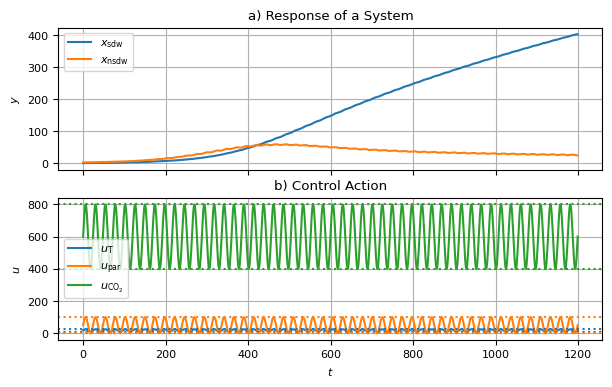

In [33]:
plot_response(t_out, y_out, u_out, u_min=u_min, u_max=u_max)
plt.show()

## Explore responses to steps in individual inputs

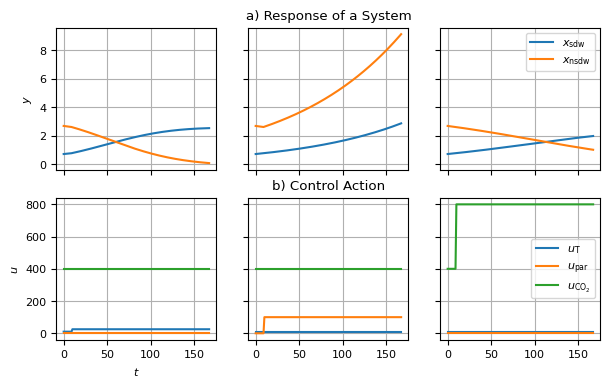

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 2].legend()

plt.show()

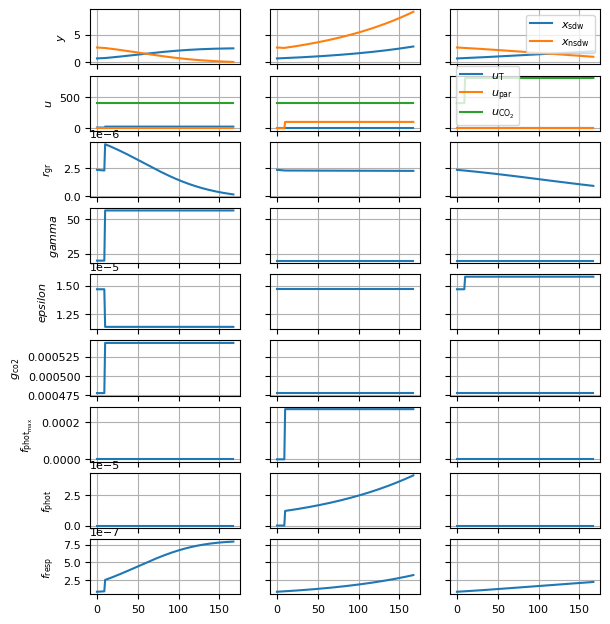

In [35]:
fig, axs = plt.subplots(
    nrows=2 + 7,
    ncols=len(u_max),
    figsize=(6, 9),
    sharex=True,
    sharey="row",
)

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

    # Replay simulation to get states
    xs = []
    for x, u in zip(y_out, u_out):
        _, _, x_ = _lettuce_growth_model(0, tuple(x), tuple(u))
        xs.append(x_)
    i = 0
    df = pd.DataFrame(xs)

    # Plot states
    plot_states(df, axs[2:, u_idx], u_idx == 0)

axs[0, 0].set_ylabel("$y$")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 2].legend()

plt.show()

## P controller for the reference tracking problem

In [36]:
u = partial(gen_u_naive_control, u_min=u_min, u_max=u_max)
ref = partial(gen_ref_step, x_step=[50, 5])

t_out, y_out, u_out, y_ref = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0, ref_gen=ref
)

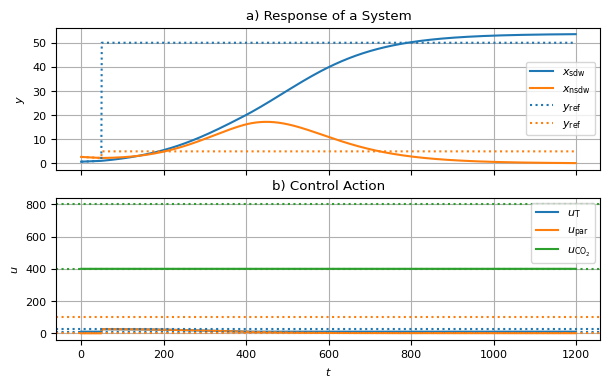

In [37]:
plot_response(t_out, y_out, u_out, y_ref=y_ref, u_min=u_min, u_max=u_max)
plt.show()

## MPC for the time-constrained reference tracking problem

In [38]:
opti = Opti()  # Optimization problem

N = 50  # number of control intervals
sec_in_day = 86400
x_ref = [50, 5]  # reference state
# ---- decision variables ---------
X = opti.variable(2, N + 1)  # state trajectory
x_sdw = X[0, :]
x_nsdw = X[1, :]
U = opti.variable(3, N)  # control trajectory (u_T, u_par, u_co2)
T = opti.variable()

# ---- objective          ---------
opti.minimize(
    # dot(X[:, 0] - x_ref[0], X[:, 0] - x_ref[0]) +
    T / sec_in_day
)  # reference tracking

# ---- dynamic constraints --------
dt = T / N  # sec_in_day  #


def f(x, u):
    return vertcat(*lettuce_growth_model(0, vertsplit(x), vertsplit(u)))


# Implement Runge-Kutta 4 integrator manually 😱
for k in range(N):
    k1 = f(X[:, k], U[:, k])
    k2 = f(X[:, k] + dt / 2 * k1, U[:, k])
    k3 = f(X[:, k] + dt / 2 * k2, U[:, k])
    k4 = f(X[:, k] + dt * k3, U[:, k])
    x_next = X[:, k] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    opti.subject_to(X[0, k + 1] == x_next[0])
    opti.subject_to(X[1, k + 1] == x_next[1])

# ---- path constraints -----------
for i in range(U.shape[0]):
    opti.subject_to(U[i, :] >= u_min[i])
    opti.subject_to(U[i, :] <= u_max[i])
for i in range(X.shape[0]):
    opti.subject_to(X[i, :] >= 0.01)

# ---- boundary conditions and initial values for solver --------
for i in range(X.shape[0]):
    opti.set_initial(X[i, :], x0[i])
    opti.subject_to(X[i, 0] == x0[i])
    # Terminal constraint on structural dry weight
    opti.subject_to(X[0, -1] >= 50)
    opti.subject_to(X[1, -1] <= 20)
    # Terminal constraint on time
    opti.subject_to(T <= sec_in_day * 15)


# ---- misc. constraints  ----------
opti.subject_to(T >= 0)  # Time must be positive

# ---- solve NLP              ------
opti.solver("ipopt")  # set numerical backend
sol = opti.solve()  # actual solve

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      702
Number of nonzeros in inequality constraint Jacobian.:      409
Number of nonzeros in Lagrangian Hessian.............:     1001

Total number of variables............................:      253
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      102
Total number of inequality constraints...............:      409
        inequality constraints with only lower bounds:      255
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      154

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+02 2.50e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

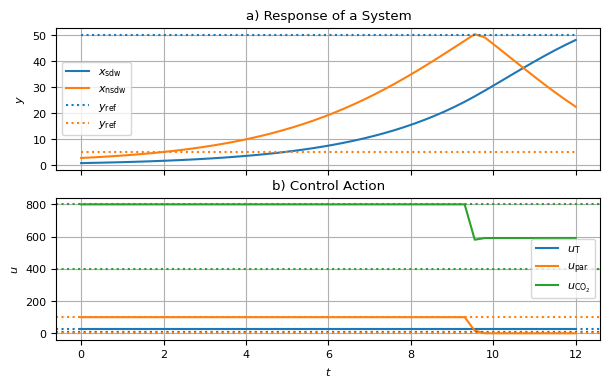

In [39]:
plot_response(
    np.linspace(0, int(sol.value(T) / sec_in_day), N),
    sol.value(X).T[:-1],
    sol.value(U).T,
    y_ref=[x_ref] * N,
    u_min=u_min,
    u_max=u_max,
)
plt.show()

### Validation using varying step simulation

In [40]:
t_out, y_out, u_out = simulate(
    lettuce_growth_model,
    u=sol.value(U).T,
    sim_time=N,
    t_s=sol.value(T) / N,
    x0=x0,
)

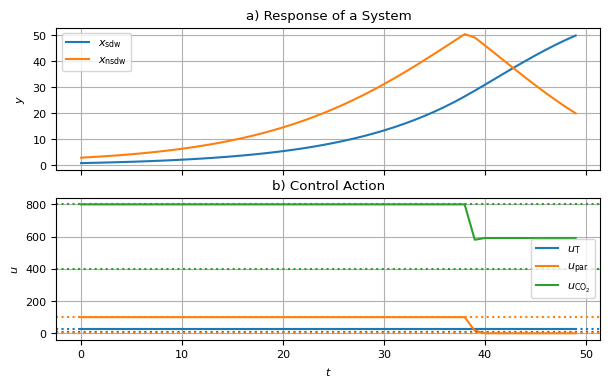

In [41]:
plot_response(
    t_out,
    y_out,
    u_out,
    # y_ref=[x_ref] * N,
    u_min=u_min,
    u_max=u_max,
)
plt.show()

## Do MPC

In [42]:
# Create a model instance
model = Model("discrete")

# Define state and control variables
x = model.set_variable(var_type="_x", var_name="x", shape=(2, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(3, 1))


def f(x, u):
    return vertcat(*lettuce_growth_model(0, vertsplit(x), vertsplit(u)))


dt = sec_in_day * 15 / N

k1 = f(x[:, 0], u[:, 0])
k2 = f(x[:, 0] + dt / 2 * k1, u[:, 0])
k3 = f(x[:, 0] + dt / 2 * k2, u[:, 0])
k4 = f(x[:, 0] + dt * k3, u[:, 0])
x_next = x[:, 0] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

model.set_rhs("x", x_next)

model.setup()

# Define parameters
N = 50  # number of control intervals
sec_in_day = 86400
x_ref = np.array([50, 5])  # reference state

# Create an MPC instance
mpc = MPC(model)

# Set parameters
setup_mpc = {
    "n_horizon": N,
    "t_step": sec_in_day,
    "store_full_solution": True,
    "use_terminal_bounds": True,
}
mpc.set_param(**setup_mpc)

# Define objective
mpc.set_objective(
    mterm=dot(x[-1, 0] - x_ref[0], x[-1, 0] - x_ref[0]),
    lterm=dot(x[:, 0] - x_ref[0], x[:, 0] - x_ref[0]),
)

mpc.set_rterm(
    u=np.array([0.1] * 3)
)  # Parametrize with size of greenhouse and Ts


mpc.terminal_bounds
# Define path constraints
mpc.bounds["lower", "_u", "u"] = u_min
mpc.bounds["upper", "_u", "u"] = u_max

mpc.bounds["lower", "_x", "x"] = [0.01, 0.01]

# Define miscellaneous constraints
# mpc.bounds["upper", "_u", "t"] = sec_in_day * 15

mpc.terminal_bounds["lower", "x"] = 50

mpc.setup()

estimator = StateFeedback(model)

# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": sec_in_day}

simulator.set_param(**params_simulator)

simulator.setup()

x0_ = np.array(x0)
mpc.x0 = x0_
simulator.x0 = x0_
estimator.x0 = x0_
mpc.set_initial_guess()

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
u0 = [float("nan")] * 3
ums = []
uos = []
for k in range(50):
    u_out = gen_u_daily_sine(k, 50 / 3, sec_in_day, u_min=u_min, u_max=u_max)
    uos.append(u_out)
    u_min_ = u_min.copy()
    u_max_ = u_max.copy()
    for i, u_real_value in enumerate(u_out):
        # Compare u_real with u
        if u_real_value > u0[i]:
            # If u_real is higher than u, update u_max
            u_max_[i] = u_real_value
            u_min_[i] = u0[i][0]
        elif u_real_value <= u0[i]:
            # Otherwise, update u_min
            u_min_[i] = u_real_value
            u_max_[i] = u0[i][0]
    ums.append([u_min_, u_max_])
    mpc.bounds["upper", "_u", "u"] = u_max
    mpc.bounds["lower", "_u", "u"] = u_min
    u0 = mpc.make_step(x0_)
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next)
    x0_ = estimator.make_step(y_next)
    x0s.append(x0_)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      898

Total number of variables............................:      252
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      150
                     variables with only upper bounds:        0
Total number of equality constraints.................:      102
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4962247e+05 4.97e+01 9.96e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

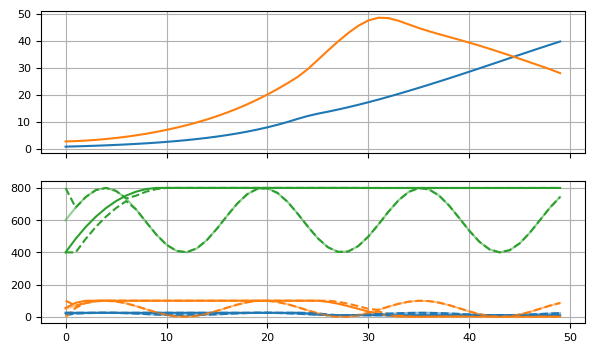

In [43]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(np.array(y_nexts).reshape(-1, 2))
axs[1].plot(np.array(u0s).reshape(-1, 3))
axs[1].set_prop_cycle(None)
axs[1].plot(np.array(ums).reshape(-1, 6)[:, :3], linestyle="--")
axs[1].set_prop_cycle(None)
axs[1].plot(np.array(ums).reshape(-1, 6)[:, 3:], linestyle="--")
axs[1].set_prop_cycle(None)
axs[1].plot(np.array(uos).reshape(-1, 3), alpha=0.5)

In [44]:
fig.savefig("stat_weather.pdf")

# Adaptive Limits for Energetic Efficiency

In [45]:
position = {"latitude": "48.14", "longitude": "17.10"}
url = "https://api.open-meteo.com/v1/forecast"
params = {
    **position,
    # "current": "temperature_2m,shortwave_radiation_instant",
    "hourly": "temperature_2m,shortwave_radiation",
    "forecast_days": "3",
    # "forecast_minutely_15": "8",
}
response = requests.get(url, params=params)
pprint(response.json())

{'elevation': 166.0,
 'generationtime_ms': 0.07104873657226562,
 'hourly': {'shortwave_radiation': [0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    7.0,
                                    44.0,
                                    115.0,
                                    205.0,
                                    161.0,
                                    188.0,
                                    158.0,
                                    111.0,
                                    104.0,
                                    209.0,
                                    120.0,
                                    19.0,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0,
              

In [46]:
weather = response.json()["hourly"]

In [47]:
weather["time"] = [datetime.fromisoformat(date) for date in weather["time"]]

In [48]:
len(weather["time"])

72

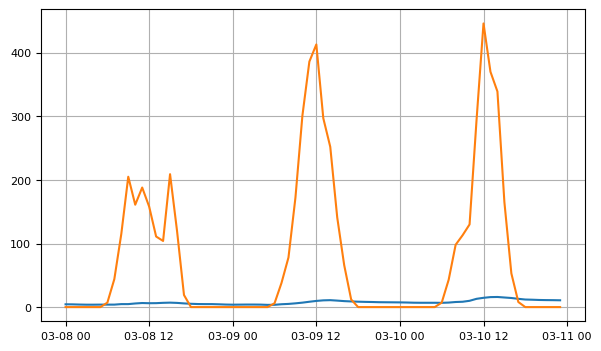

In [49]:
plt.plot(weather["time"], weather["temperature_2m"])
plt.plot(weather["time"], weather["shortwave_radiation"])

In [50]:
# Create a model instance
model = Model("discrete")

# Define state and control variables
x = model.set_variable(var_type="_x", var_name="x", shape=(2, 1))
u = model.set_variable(var_type="_u", var_name="u", shape=(3, 1))


def f(x, u):
    return vertcat(*lettuce_growth_model(0, vertsplit(x), vertsplit(u)))


dt = sec_in_day * 15 / N

k1 = f(x[:, 0], u[:, 0])
k2 = f(x[:, 0] + dt / 2 * k1, u[:, 0])
k3 = f(x[:, 0] + dt / 2 * k2, u[:, 0])
k4 = f(x[:, 0] + dt * k3, u[:, 0])
x_next = x[:, 0] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

model.set_rhs("x", x_next)

model.setup()

# Define parameters
N = 50  # number of control intervals
sec_in_day = 86400
x_ref = np.array([50, 5])  # reference state
u_min = [-10, 0, 400]
u_max = [25, 200, 800]

# Create an MPC instance
mpc = MPC(model)

# Set parameters
setup_mpc = {
    "n_horizon": N,
    "t_step": sec_in_day,
    "store_full_solution": True,
    "use_terminal_bounds": True,
}
mpc.set_param(**setup_mpc)

# Define objective
mpc.set_objective(
    mterm=dot(x[-1, 0] - x_ref[0], x[-1, 0] - x_ref[0]),
    lterm=dot(x[:, 0] - x_ref[0], x[:, 0] - x_ref[0]),
)

mpc.set_rterm(
    u=np.array([0.1] * 3)
)  # Parametrize with size of greenhouse and Ts


# mpc.terminal_bounds
# Define path constraints
mpc.bounds["lower", "_u", "u"] = u_min
mpc.bounds["upper", "_u", "u"] = u_max

mpc.bounds["lower", "_x", "x"] = [0.01, 0.01]

# Define miscellaneous constraints
# mpc.bounds["upper", "_u", "t"] = sec_in_day * 15

mpc.terminal_bounds["lower", "x"] = 50

mpc.setup()

estimator = StateFeedback(model)

# Create a simulator
simulator = Simulator(model)

params_simulator = {"t_step": sec_in_day}

simulator.set_param(**params_simulator)

simulator.setup()

x0_ = np.array(x0)
mpc.x0 = x0_
simulator.x0 = x0_
estimator.x0 = x0_
mpc.set_initial_guess()

# Run the MPC simulation
u0s = []
y_nexts = []
x0s = []
u0 = [float("nan")] * 3
ums = []
uos = []
for k in range(50):
    u_out = [
        weather["temperature_2m"][k],
        weather["shortwave_radiation"][k],
        float("nan"),
    ]
    uos.append(u_out)
    u_min_ = u_min.copy()
    u_max_ = u_max.copy()
    for i, u_real_value in enumerate(u_out):
        # Compare u_real with u
        if u_real_value > u0[i]:
            # If u_real is higher than u, update u_max
            u_max_[i] = u_real_value
            u_min_[i] = u0[i][0]
        elif u_real_value <= u0[i]:
            # Otherwise, update u_min
            u_min_[i] = u_real_value
            u_max_[i] = u0[i][0]
    ums.append([u_min_, u_max_])
    mpc.bounds["upper", "_u", "u"] = u_max_
    mpc.bounds["lower", "_u", "u"] = u_min_
    u0 = mpc.make_step(x0_)
    u0s.append(u0)
    y_next = simulator.make_step(u0)
    y_nexts.append(y_next)
    x0_ = estimator.make_step(y_next)
    x0s.append(x0_)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      898

Total number of variables............................:      252
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      150
                     variables with only upper bounds:        0
Total number of equality constraints.................:      102
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4961227e+05 4.98e+01 9.96e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

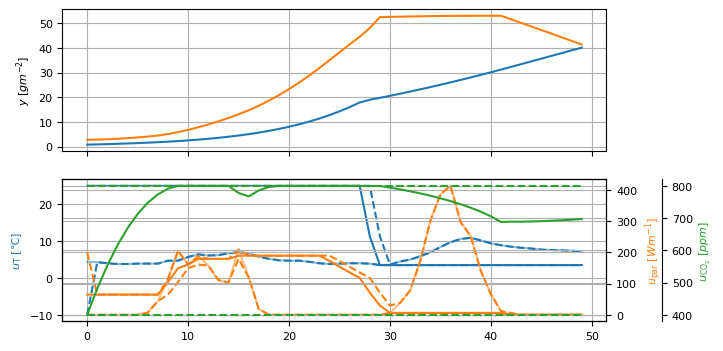

In [51]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(np.array(y_nexts).reshape(-1, 2))
axs[0].set_ylabel("$y~[g m^{-2}]$")
for i, (label, color) in enumerate(
    zip(
        [
            r"$u_{\mathrm{T}}~[℃]$",
            r"$u_{\mathrm{par}}~[W m^{-1}]$",
            r"$u_{\mathrm{CO_2}}~[ppm]$",
        ],
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
    )
):
    if i > 0:
        ax = axs[1].twinx()
    else:
        ax = axs[1]
    if i > 1:
        ax.spines["right"].set_position(("outward", 20 * i))
    ax.plot(np.array(u0s).reshape(-1, 3)[:, i], color=color)
    ax.plot(np.array(ums).reshape(-1, 6)[:, i], linestyle="--", color=color)
    ax.plot(
        np.array(ums).reshape(-1, 6)[:, i + 3], linestyle="--", color=color
    )
    ax.plot(np.array(uos).reshape(-1, 3)[:, i], alpha=0.5, color=color)
    ax.set_ylabel(label, color=color)